In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

In [3]:
def sobel_gradient(img_rgb, ksize=3, sigma = 0.5):
    """
    Lab vector gradient magnitude.

    Parameters:
    img_rgb : Input RGB image (H, W, 3) uint8
    ksize : Sobel kernel size int (3-5)
    threshold : Threshold in [0,1] after normalization

    Returns:
    magnitude : Gradient magnitude (H, W) float32
    """

    # RGB -> Lab (OpenCV uses D65, sobel needs floating points)
    # Each point is a vector in R^3
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    lab = cv2.GaussianBlur(lab, (0, 0), sigma)

    # Compute spatial gradients per channel c = l, a, b
    gx = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in x direction
    gy = np.zeros(lab.shape[:2], dtype=np.float32) # gradient in y direction

    for c in range(3):
        gx_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 1, 0, ksize=ksize)
        gy_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 0, 1, ksize=ksize)
        gx += gx_c 
        gy += gy_c 

    # Vector gradient magnitude
    magnitude = np.sqrt(gx**2 + gy**2)

    # Vector gradient direction
    direction = np.arctan2(gy, gx)

    # Normalize gradient magnitude
    magnitude /= magnitude.max() + 1e-8

    return magnitude, direction

## Load in Fuji

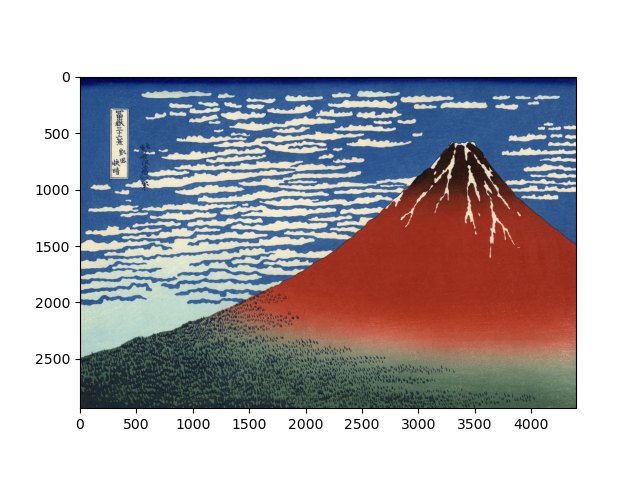

In [48]:
%matplotlib widget

img = cv2.imread('red_fuji3.jpg') # high res
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to LAB 
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

height, width, _ = img.shape

plt.imshow(img)
plt.show()

## Color segmentation

#### SLICO super pixels then DBSCAN/OPTICS
Does not work because the super pixels result in too much loss of detail

In [46]:
from skimage.segmentation import slic

# Compute SLIC superpixels
segments = slic(img, n_segments=1500, compactness=0.01, start_label=0, slic_zero=True)

num_segments = segments.max() + 1

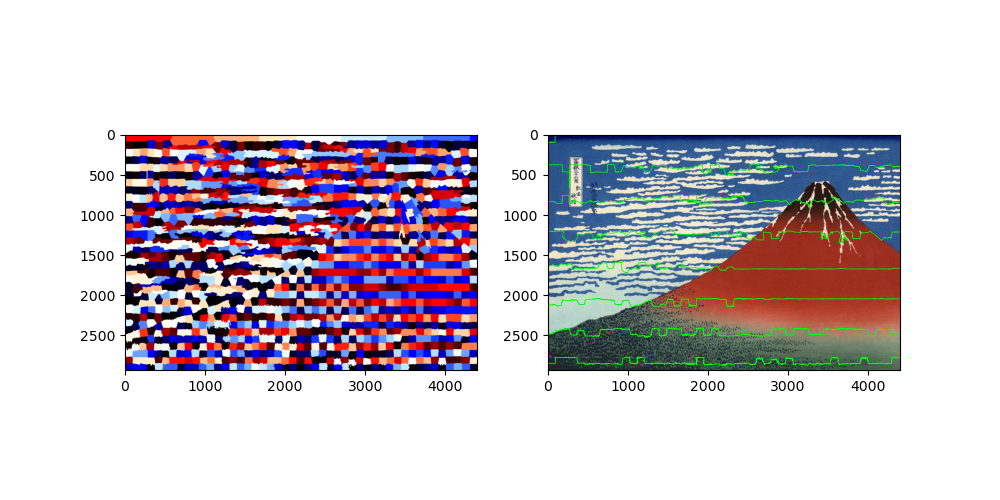

In [32]:
plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(segments, cmap = 'flag')
ax[1].imshow(img)
ax[1].contour(segments, colors='lime', linewidths=0.5)
plt.show()

In [34]:
median_colors = np.zeros((num_segments, 3))

for label in range(num_segments):
    mask = segments == label
    median_colors[label] = np.median(img_lab[mask], axis=0)

In [36]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=8,min_samples=5)

cluster_labels = db.fit_predict(median_colors)

In [38]:
clustered_image = np.zeros_like(img)

for seg_label in range(num_segments):
    cluster_id = cluster_labels[seg_label]
    mask = segments == seg_label

    if cluster_id == -1:
        clustered_image[mask] = [0, 0, 0]  # optional noise color
    else:
        clustered_image[mask] = img[mask].mean(axis=0)

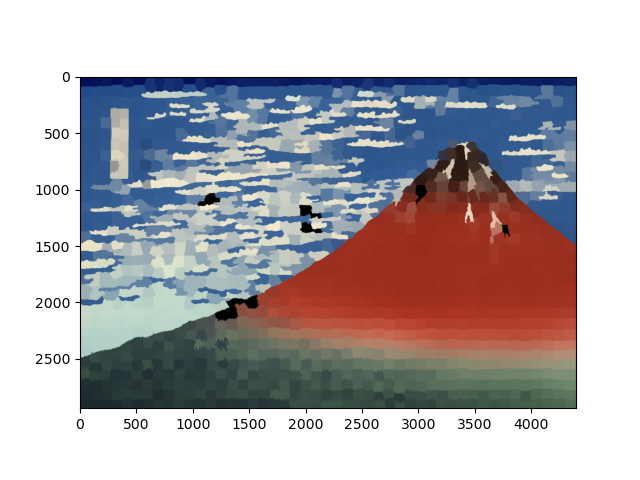

In [42]:
plt.close()
plt.imshow(clustered_image)
plt.show()

#### Overcluster then merge

In [52]:
from sklearn.cluster import MiniBatchKMeans

pixels = img_lab.reshape(-1, 3)
k_initial = 25  # overspecify

# Mini Batch K-means
kmeans = MiniBatchKMeans(
    n_clusters=k_initial,
    batch_size=10000,
    random_state=42,
    n_init=10
)

labels = kmeans.fit_predict(pixels) # labels shape (HxW)
centroids = kmeans.cluster_centers_ # color centers (25)

In [86]:
from scipy.spatial.distance import cdist

merge_threshold = 20  # tune (5–12 typical)

# Compute pairwise distances
dist_matrix = cdist(centroids, centroids)

# Build adjacency graph of similar clusters
merge_map = np.arange(k_initial)

# Merge similar clusters
for i in range(k_initial):
    for j in range(i + 1, k_initial):
        if dist_matrix[i, j] < merge_threshold:
            merge_map[merge_map == j] = i

In [88]:
# Reindex merged clusters
unique_clusters = np.unique(merge_map)
cluster_remap = {old: new for new, old in enumerate(unique_clusters)}

final_labels = np.array([cluster_remap[merge_map[l]] for l in labels])

# Recreate image
final_centroids = []

for c in unique_clusters:
    mask = final_labels == cluster_remap[c]
    final_centroids.append(pixels[mask].mean(axis=0))

final_centroids = np.array(final_centroids)

segmented_lab = final_centroids[final_labels]
segmented_lab = segmented_lab.reshape(height, width, 3).astype(np.uint8)

segmented_rgb = cv2.cvtColor(segmented_lab, cv2.COLOR_LAB2RGB)
print('Number of clusters:', len(final_centroids))

Number of clusters: 16


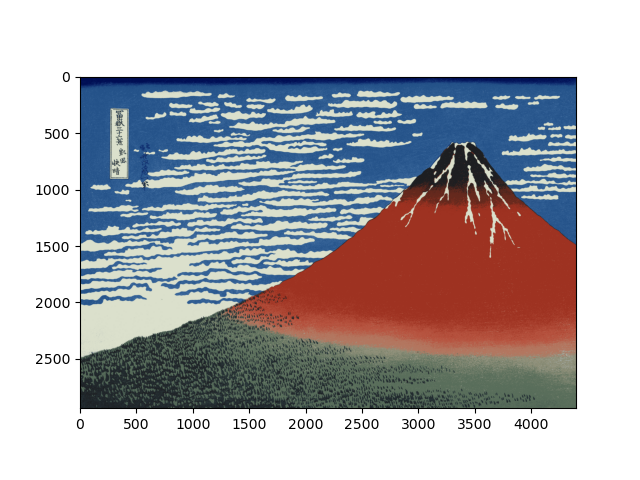

In [79]:
plt.close()
plt.imshow(segmented_rgb)
plt.show()